In [1]:
# Asthetics
import warnings
import sklearn.exceptions
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

# General
from kaggle_datasets import KaggleDatasets
from glob import glob
import pandas as pd
import numpy as np
import os
import time
import cv2
import random
import shutil
import math
import re
pd.set_option('display.max_columns', None)

# Visualizations
from PIL import Image
from plotly.subplots import make_subplots
from plotly.offline import iplot
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.express as px
%matplotlib inline
sns.set(style="whitegrid")

# Machine Learning
# Pre Procesing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# Models
from sklearn.model_selection import train_test_split, KFold
# Deep Learning
import tensorflow as tf
import tensorflow.keras.backend as K
#import efficientnet.tfkeras as efn
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
import tensorflow_addons as tfa
from tensorflow_addons.metrics import F1Score, FBetaScore
from tensorflow_addons.callbacks import TQDMProgressBar
from tensorflow.keras.utils import plot_model

#Metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

print('TF',tf.__version__)

# Random Seed Fixing
RANDOM_SEED = 42

def seed_everything(seed=RANDOM_SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

seed_everything()

TF 2.4.1


In [2]:
# From https://www.kaggle.com/xhlulu/ranzcr-efficientnet-tpu-training
def auto_select_accelerator():
    TPU_DETECTED = False
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
        print("Running on TPU:", tpu.master())
        TPU_DETECTED =True
    except ValueError:
        strategy = tf.distribute.get_strategy()
    print(f"Running on {strategy.num_replicas_in_sync} replicas")
    
    return strategy, TPU_DETECTED

# CFG

In [3]:
# Model Params
KFOLDS = 4
IMG_SIZES = [256]*KFOLDS
BATCH_SIZES = [64]*KFOLDS
EPOCHS = [15]*KFOLDS
EFF_NETS = [0]*KFOLDS # WHICH EFFICIENTNET B? TO USE

# Model Eval Params
DISPLAY_PLOT = True

# Inference Params
WGTS = [1/KFOLDS]*KFOLDS

In [4]:
strategy, TPU_DETECTED = auto_select_accelerator()
AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync

Running on TPU: grpc://10.0.0.2:8470
Running on 8 replicas


In [5]:
from tqdm.notebook import tqdm

files_test_g = []
for i,k in tqdm([(0, 1), (2, 3), (4, 5), (6, 7)]):
    GCS_PATH = KaggleDatasets().get_gcs_path(f'cqt-g2net-test-{i}-{k}')
    files_test_g.extend(np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/test*.tfrec'))).tolist())
num_train_files = len(files_test_g)
print('test_files:',num_train_files)

  0%|          | 0/4 [00:00<?, ?it/s]

test_files: 8


# Reading Tfrecords

In [6]:
def read_labeled_tfrecord(example):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_id'                     : tf.io.FixedLenFeature([], tf.string),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    }           
    example = tf.io.parse_single_example(example, tfrec_format)
    return prepare_image(example['image']), tf.reshape(tf.cast(example['target'], tf.float32), [1])


def read_unlabeled_tfrecord(example, return_image_id):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_id'                     : tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    return prepare_image(example['image']), example['image_id'] if return_image_id else 0

 
def prepare_image(img, dim=IMG_SIZES[0]):    
    img = tf.image.resize(tf.image.decode_png(img, channels=3), size=(dim, dim))
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.reshape(img, [dim,dim, 3])
            
    return img

def count_data_items(fileids):
    n = [int(re.compile(r"-([0-9]*)\.").search(fileid).group(1)) 
         for fileid in fileids]
    return np.sum(n)

# Dataset Creation

In [7]:
def get_dataset(files, shuffle = False, repeat = False, 
                labeled=True, return_image_ids=True, batch_size=16, dim=IMG_SIZES[0]):
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(1024*2)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
        
    if labeled: 
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_ids), 
                    num_parallel_calls=AUTO)      
    
    ds = ds.batch(batch_size * REPLICAS)
    ds = ds.prefetch(AUTO)
    return ds

# Build Model

In [8]:
"""
Creates a EfficientNetV2 Model as defined in:
Mingxing Tan, Quoc V. Le. (2021).
EfficientNetV2: Smaller Models and Faster Training
arXiv preprint arXiv:2104.00298.
"""
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Activation,
    Add,
    BatchNormalization,
    Conv2D,
    Dense,
    DepthwiseConv2D,
    Dropout,
    GlobalAveragePooling2D,
    Input,
    PReLU,
    Reshape,
    Multiply,
)

BATCH_NORM_DECAY = 0.9
BATCH_NORM_EPSILON = 0.001
CONV_KERNEL_INITIALIZER = keras.initializers.VarianceScaling(scale=2.0, mode="fan_out", distribution="truncated_normal")
# CONV_KERNEL_INITIALIZER = 'glorot_uniform'

BLOCK_CONFIGS = {
    "b0": {  # width 1.0, depth 1.0
        "first_conv_filter": 32,
        "expands": [1, 4, 4, 4, 6, 6],
        "out_channels": [16, 32, 48, 96, 112, 192],
        "depthes": [1, 2, 2, 3, 5, 8],
        "strides": [1, 2, 2, 2, 1, 2],
        "use_ses": [0, 0, 0, 1, 1, 1],
    },
    "b1": {  # width 1.0, depth 1.1
        "first_conv_filter": 32,
        "expands": [1, 4, 4, 4, 6, 6],
        "out_channels": [16, 32, 48, 96, 112, 192],
        "depthes": [2, 3, 3, 4, 6, 9],
        "strides": [1, 2, 2, 2, 1, 2],
        "use_ses": [0, 0, 0, 1, 1, 1],
    },
    "b2": {  # width 1.1, depth 1.2
        "first_conv_filter": 32,
        "output_conv_filter": 1408,
        "expands": [1, 4, 4, 4, 6, 6],
        "out_channels": [16, 32, 56, 104, 120, 208],
        "depthes": [2, 3, 3, 4, 6, 10],
        "strides": [1, 2, 2, 2, 1, 2],
        "use_ses": [0, 0, 0, 1, 1, 1],
    },
    "b3": {  # width 1.2, depth 1.4
        "first_conv_filter": 40,
        "output_conv_filter": 1536,
        "expands": [1, 4, 4, 4, 6, 6],
        "out_channels": [16, 40, 56, 112, 136, 232],
        "depthes": [2, 3, 3, 5, 7, 12],
        "strides": [1, 2, 2, 2, 1, 2],
        "use_ses": [0, 0, 0, 1, 1, 1],
    },
    "s": {  # width 1.4, depth 1.8
        "first_conv_filter": 24,
        "output_conv_filter": 1280,
        "expands": [1, 4, 4, 4, 6, 6],
        "out_channels": [24, 48, 64, 128, 160, 256],
        "depthes": [2, 4, 4, 6, 9, 15],
        "strides": [1, 2, 2, 2, 1, 2],
        "use_ses": [0, 0, 0, 1, 1, 1],
    },
    "m": {  # width 1.6, depth 2.2
        "first_conv_filter": 24,
        "output_conv_filter": 1280,
        "expands": [1, 4, 4, 4, 6, 6, 6],
        "out_channels": [24, 48, 80, 160, 176, 304, 512],
        "depthes": [3, 5, 5, 7, 14, 18, 5],
        "strides": [1, 2, 2, 2, 1, 2, 1],
        "use_ses": [0, 0, 0, 1, 1, 1, 1],
    },
    "l": {  # width 2.0, depth 3.1
        "first_conv_filter": 32,
        "output_conv_filter": 1280,
        "expands": [1, 4, 4, 4, 6, 6, 6],
        "out_channels": [32, 64, 96, 192, 224, 384, 640],
        "depthes": [4, 7, 7, 10, 19, 25, 7],
        "strides": [1, 2, 2, 2, 1, 2, 1],
        "use_ses": [0, 0, 0, 1, 1, 1, 1],
    },
    "xl": {
        "first_conv_filter": 32,
        "output_conv_filter": 1280,
        "expands": [1, 4, 4, 4, 6, 6, 6],
        "out_channels": [32, 64, 96, 192, 256, 512, 640],
        "depthes": [4, 8, 8, 16, 24, 32, 8],
        "strides": [1, 2, 2, 2, 1, 2, 1],
        "use_ses": [0, 0, 0, 1, 1, 1, 1],
    },
}


def _make_divisible(v, divisor=4, min_value=None):
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


def conv2d_no_bias(inputs, filters, kernel_size, strides=1, padding="VALID", name=""):
    return Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=False, kernel_initializer=CONV_KERNEL_INITIALIZER, name=name + "conv"
    )(inputs)

def batchnorm_with_activation(inputs, activation="swish", name=""):
    """Performs a batch normalization followed by an activation. """
    bn_axis = 1 if K.image_data_format() == "channels_first" else -1
    nn = BatchNormalization(
        axis=bn_axis,
        momentum=BATCH_NORM_DECAY,
        epsilon=BATCH_NORM_EPSILON,
        name=name + "bn",
    )(inputs)
    if activation:
        nn = Activation(activation=activation, name=name + activation)(nn)
        # nn = PReLU(shared_axes=[1, 2], alpha_initializer=tf.initializers.Constant(0.25), name=name + "PReLU")(nn)
    return nn

def se_module(inputs, se_ratio=4, name=""):
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    h_axis, w_axis = [2, 3] if K.image_data_format() == "channels_first" else [1, 2]

    filters = inputs.shape[channel_axis]
    # reduction = _make_divisible(filters // se_ratio, 8)
    reduction = filters // se_ratio
    # se = GlobalAveragePooling2D()(inputs)
    # se = Reshape((1, 1, filters))(se)
    se = tf.reduce_mean(inputs, [h_axis, w_axis], keepdims=True)
    se = Conv2D(reduction, kernel_size=1, use_bias=True, kernel_initializer=CONV_KERNEL_INITIALIZER, name=name + "1_conv")(se)
    # se = PReLU(shared_axes=[1, 2])(se)
    se = Activation("swish")(se)
    se = Conv2D(filters, kernel_size=1, use_bias=True, kernel_initializer=CONV_KERNEL_INITIALIZER, name=name + "2_conv")(se)
    se = Activation("sigmoid")(se)
    return Multiply()([inputs, se])


def MBConv(inputs, output_channel, stride, expand_ratio, shortcut, survival=None, use_se=0, is_fused=False, name=""):
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    input_channel = inputs.shape[channel_axis]

    if is_fused and expand_ratio != 1:
        nn = conv2d_no_bias(inputs, input_channel * expand_ratio, (3, 3), strides=stride, padding="same", name=name + "sortcut_")
        nn = batchnorm_with_activation(nn, name=name + "sortcut_")
    elif expand_ratio != 1:
        nn = conv2d_no_bias(inputs, input_channel * expand_ratio, (1, 1), strides=(1, 1), padding="same", name=name + "sortcut_")
        nn = batchnorm_with_activation(nn, name=name + "sortcut_")
    else:
        nn = inputs

    if not is_fused:
        nn = DepthwiseConv2D(
            (3, 3), padding="same", strides=stride, use_bias=False, depthwise_initializer=CONV_KERNEL_INITIALIZER, name=name + "MB_dw_"
        )(nn)
        nn = batchnorm_with_activation(nn, name=name + "MB_dw_")

    if use_se:
        nn = se_module(nn, se_ratio=4 * expand_ratio, name=name + "se_")

    # pw-linear
    if is_fused and expand_ratio == 1:
        nn = conv2d_no_bias(nn, output_channel, (3, 3), strides=stride, padding="same", name=name + "fu_")
        nn = batchnorm_with_activation(nn, name=name + "fu_")
    else:
        nn = conv2d_no_bias(nn, output_channel, (1, 1), strides=(1, 1), padding="same", name=name + "MB_pw_")
        nn = batchnorm_with_activation(nn, activation=None, name=name + "MB_pw_")

    if shortcut:
        if survival is not None and survival < 1:
            from tensorflow_addons.layers import StochasticDepth

            return StochasticDepth(float(survival))([inputs, nn])
        else:
            return Add()([inputs, nn])
    else:
        return nn


def EfficientNetV2(
    model_type,
    input_shape=(None, None, 3),
    classes=1000,
    dropout=0.2,
    first_strides=2,
    survivals=None,
    classifier_activation="softmax",
    pretrained="imagenet21k-ft1k",
    name="EfficientNetV2",
):
    """
    model_type: is the pre-defined model, value in ["s", "m", "l", "b0", "b1", "b2", "b3"].
    classes: Output classes number, 0 to exclude top layers.
    first_strides: is used in the first Conv2D layer.
    survivals: is used for [Deep Networks with Stochastic Depth](https://arxiv.org/abs/1603.09382).
        Can be a constant value like `0.5` or `0.8`,
        or a tuple value like `(1, 0.8)` indicates the survival probability linearly changes from `1 --> 0.8` for `top --> bottom` layers.
        A higher value means a higher probability will keep the conv branch.
        or `None` to disable.
    pretrained: value in [None, "imagenet", "imagenet21k", "imagenet21k-ft1k"]. Save path is `~/.keras/models/efficientnetv2/`.
    """
    blocks_config = BLOCK_CONFIGS.get(model_type.lower(), BLOCK_CONFIGS["s"])
    expands = blocks_config["expands"]
    out_channels = blocks_config["out_channels"]
    depthes = blocks_config["depthes"]
    strides = blocks_config["strides"]
    use_ses = blocks_config["use_ses"]
    first_conv_filter = blocks_config.get("first_conv_filter", out_channels[0])
    output_conv_filter = blocks_config.get("output_conv_filter", 1280)

    inputs = Input(shape=input_shape)
    out_channel = _make_divisible(first_conv_filter, 8)
    nn = conv2d_no_bias(inputs, out_channel, (3, 3), strides=first_strides, padding="same", name="stem_")
    nn = batchnorm_with_activation(nn, name="stem_")

    # StochasticDepth survival_probability values
    total_layers = sum(depthes)
    if isinstance(survivals, float):
        survivals = [survivals] * total_layers
    elif isinstance(survivals, (list, tuple)) and len(survivals) == 2:
        start, end = survivals
        survivals = [start - (1 - end) * float(ii) / total_layers for ii in range(total_layers)]
    else:
        survivals = [None] * total_layers
    survivals = [survivals[int(sum(depthes[:id])) : sum(depthes[: id + 1])] for id in range(len(depthes))]

    pre_out = out_channel
    for id, (expand, out_channel, depth, survival, stride, se) in enumerate(zip(expands, out_channels, depthes, survivals, strides, use_ses)):
        out = _make_divisible(out_channel, 8)
        is_fused = True if se == 0 else False
        for block_id in range(depth):
            stride = stride if block_id == 0 else 1
            shortcut = True if out == pre_out and stride == 1 else False
            name = "stack_{}_block{}_".format(id, block_id)
            nn = MBConv(nn, out, stride, expand, shortcut, survival[block_id], se, is_fused, name=name)
            pre_out = out

    output_conv_filter = _make_divisible(output_conv_filter, 8)
    nn = conv2d_no_bias(nn, output_conv_filter, (1, 1), strides=(1, 1), padding="valid", name="post_")
    nn = batchnorm_with_activation(nn, name="post_")

    if classes > 0:
        nn = GlobalAveragePooling2D(name="avg_pool")(nn)
        if dropout > 0 and dropout < 1:
            nn = Dropout(dropout)(nn)
        nn = Dense(classes, activation=classifier_activation, name="predictions")(nn)
    model = Model(inputs=inputs, outputs=nn, name=name)

    pretrained_dd = {"imagenet": "imagenet", "imagenet21k": "21k", "imagenet21k-ft1k": "21k-ft1k"}
    if pretrained in pretrained_dd:
        pre_url = "https://github.com/leondgarse/Keras_efficientnet_v2/releases/download/v1.0.0/efficientnetv2-{}-{}.h5"
        url = pre_url.format(model_type, pretrained_dd[pretrained])
        file_name = os.path.basename(url)
        pretrained_model = keras.utils.get_file(file_name, url, cache_subdir="models/efficientnetv2")
        model.load_weights(pretrained_model, by_name=True, skip_mismatch=True)
    return model

def EfficientNetV2B0(
    input_shape=(None, None, 3),
    classes=1000,
    dropout=0.2,
    first_strides=2,
    survivals=None,
    classifier_activation="softmax",
    pretrained="imagenet21k",
    name="EfficientNetV2B0",
):
    return EfficientNetV2(model_type="b0", **locals())

def EfficientNetV2B1(
    input_shape=(None, None, 3),
    classes=1000,
    dropout=0.2,
    first_strides=2,
    survivals=None,
    classifier_activation="softmax",
    pretrained="imagenet21k",
    name="EfficientNetV2B1",
):
    return EfficientNetV2(model_type="b1", **locals())

def EfficientNetV2B2(
    input_shape=(None, None, 3),
    classes=1000,
    dropout=0.2,
    first_strides=2,
    survivals=None,
    classifier_activation="softmax",
    pretrained="imagenet21k",
    name="EfficientNetV2B2",
):
    return EfficientNetV2(model_type="b2", **locals())

def EfficientNetV2B3(
    input_shape=(None, None, 3),
    classes=1000,
    dropout=0.2,
    first_strides=2,
    survivals=None,
    classifier_activation="softmax",
    pretrained="imagenet21k",
    name="EfficientNetV2B3",
):
    return EfficientNetV2(model_type="b3", **locals())

def EfficientNetV2S(
    input_shape=(None, None, 3),
    classes=1000,
    dropout=0.2,
    first_strides=2,
    survivals=None,
    classifier_activation="softmax",
    pretrained="imagenet21k",
    name="EfficientNetV2S",
):
    return EfficientNetV2(model_type="s", **locals())


def EfficientNetV2M(
    input_shape=(None, None, 3),
    classes=1000,
    dropout=0.3,
    first_strides=2,
    survivals=None,
    classifier_activation="softmax",
    pretrained="imagenet21k",
    name="EfficientNetV2M",
):
    return EfficientNetV2(model_type="m", **locals())


def EfficientNetV2L(
    input_shape=(None, None, 3),
    classes=1000,
    dropout=0.4,
    first_strides=2,
    survivals=None,
    classifier_activation="softmax",
    pretrained="imagenet21k",
    name="EfficientNetV2L",
):
    return EfficientNetV2(model_type="l", **locals())


def EfficientNetV2XL(
    input_shape=(None, None, 3),
    classes=1000,
    dropout=0.4,
    first_strides=2,
    survivals=None,
    classifier_activation="softmax",
    pretrained="imagenet21k",
    name="EfficientNetV2XL",
):
    return EfficientNetV2(model_type="xl", **locals())

def get_actual_survival_probabilities(model):
    from tensorflow_addons.layers import StochasticDepth
    return [ii.survival_probability for ii in model.layers if isinstance(ii, StochasticDepth)]


In [9]:
EFNS = [EfficientNetV2B0, EfficientNetV2B1, EfficientNetV2B2, EfficientNetV2B3, 
        EfficientNetV2S, EfficientNetV2M, EfficientNetV2L, EfficientNetV2XL]

def build_model(size, ef=0, count=820):
    inp = tf.keras.layers.Input(shape=(size, size,3))
    base = EFNS[ef](input_shape=(size, size, 3), survivals=None, dropout=0.5, classes=0, pretrained=None)
    #base.load_weights("../input/efficientnetv2-pretrained-weights/efficientnetv2-b0-21k-notop.h5")
    
    x = base(inp)
    
    x = tf.keras.layers.GlobalAvgPool2D()(x)
    
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(1,activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inp, outputs=x)
    lr_decayed_fn = tf.keras.experimental.CosineDecay(
                              1e-3,
                              count,
    )

    opt = tfa.optimizers.AdamW(lr_decayed_fn, learning_rate=1e-4)
    loss = tf.keras.losses.BinaryCrossentropy() 
    model.compile(optimizer=opt,loss=loss,metrics=['AUC'])
    return model

# Evaluate

#########################
#### FOLD 1
	Loading model...
	Predict...


0it [00:00, ?it/s]

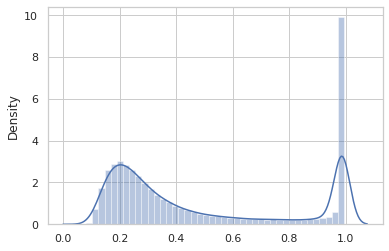

	Finished...
#########################
#### FOLD 2
	Loading model...
	Predict...


0it [00:00, ?it/s]

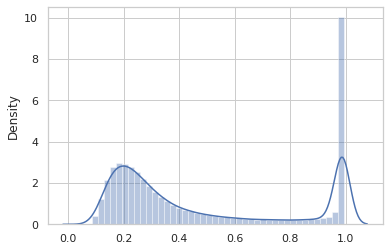

	Finished...
#########################
#### FOLD 3
	Loading model...
	Predict...


0it [00:00, ?it/s]

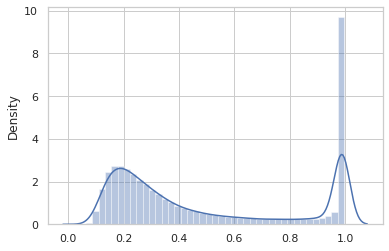

	Finished...
#########################
#### FOLD 4
	Loading model...
	Predict...


0it [00:00, ?it/s]

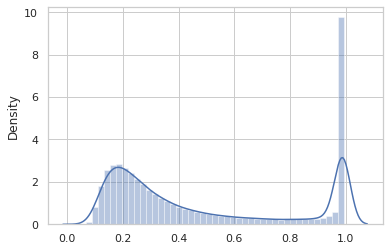

	Finished...


In [10]:
skf = KFold(n_splits=KFOLDS,shuffle=True,random_state=RANDOM_SEED)
oof_pred = []; oof_tar = []; oof_val = []; oof_f1 = []; oof_ids = []; oof_folds = [] 

files_test_g = np.array(files_test_g)

for fold in range(0, KFOLDS):
    
    print('#'*25); print('#### FOLD',fold+1)
    # BUILD MODEL
    K.clear_session()
    
    with strategy.scope():
        model = build_model(IMG_SIZES[fold], ef=EFF_NETS[fold])
    print('\tLoading model...')
    
    model.load_weights(f'../input/cqt-g2net-efficientnetv2-training/fold-{fold}.h5')  
    
    print('\tPredict...')
    ds_test = get_dataset(files_test_g,labeled=False,return_image_ids=True,
            repeat=False,shuffle=False,dim=IMG_SIZES[fold],batch_size=BATCH_SIZES[fold]*2)
    
    _oof_pred = []
    _oof_tar = []
    for img, target in tqdm(iter(ds_test)):
        p = model.predict(img).flatten()
        t = target.numpy().flatten()
        _oof_pred.extend(p.tolist())
        _oof_tar.extend(t.tolist())
    oof_pred.append(np.array(_oof_pred).flatten())
    oof_ids.append(np.array(_oof_tar).flatten())
    sns.distplot(oof_pred[-1])
    plt.show()               
    print('\tFinished...')

In [11]:
sub = pd.read_csv('../input/g2net-gravitational-wave-detection/sample_submission.csv')
sub['id'] = [t.decode("utf-8") for t in oof_ids[-1]]
sub['target'] = np.mean(oof_pred, axis=0)
sub = sub.sort_values('id') 
sub.head()

,id,target
0,00005bced6,0.989420
8,0000806717,0.659843
16,0000ef4fe1,0.430433
24,00020de251,0.773947
32,00024887b5,0.143258


In [12]:
sub.to_csv('submission.csv', index=False)